<a href="https://colab.research.google.com/github/SergioCarmo-ro/Classifica-o-e-Valida-o-de-M-tricas/blob/main/monit_aluno_tempo_real.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**PROJETO MONITORAMENTO DE ALUNOS EM TEMPO REAL**

In [28]:
!pip install numpy
!pip install matplotlib
!pip install tensorflow
!pip install pyrealsense2
!pip install mtcnn
!pip install lz4
!pip install opencv-python
!pip install tensorflow==2.18.0

In [29]:
import tensorflow as tf
import cv2
import numpy as np
from scipy.io import loadmat, savemat
from matplotlib import pyplot as plt
import pandas as pd
import cv2
from PIL import Image
import mtcnn
from mtcnn.mtcnn import MTCNN
from matplotlib.patches import Rectangle
from os import listdir
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import seaborn as sns
# Importe funções do repo (ex.: utils, renderer)

In [30]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [31]:
import tensorflow as tf

# Crie uma definição de gráfico vazia
graph_def = tf.compat.v1.GraphDef()

# Especifique o caminho para seu arquivo protobuf
protobuf_file_path ='/content/drive/MyDrive/Alunos/'

# Abra o arquivo protobuf e analise seu conteúdo na definição do gráfico
try:
    with tf.io.gfile.GFile(protobuf_file_path, 'rb') as f:
        graph_def.ParseFromString(f.read())

    # Importe a definição do gráfico para o gráfico padrão do TensorFlow
    tf.import_graph_def(graph_def, name='')

    print(f"Definição de gráfico carregada com sucesso '{protobuf_file_path}'")

except tf.errors.NotFoundError:
    print(f"Error: O Arquivo '{protobuf_file_path}' não foi encontrado.")
except Exception as e:
    print(f"Ocorreu um erro: {e}")

Ocorreu um erro: /content/drive/MyDrive/Alunos; Is a directory


In [33]:
import tensorflow as tf
import os
from google.colab import drive

# 1. Defina o caminho principal da sua pasta de imagens
data_dir = '/content/drive/MyDrive/Alunos/'
batch_size = 32
img_height = 224  # Defina a altura desejada para suas imagens
img_width = 224   # Defina a largura desejada para suas imagens

# 2. Use a função image_dataset_from_directory para criar o Dataset
image_dataset = None # Initialize image_dataset to None

# Check if the directory exists
if not os.path.exists(data_dir):
    print(f"Error: The directory '{data_dir}' was not found.")
    print("Please check if the Google Drive is mounted correctly and the path is accurate.")
else:
    try:
        # Esta função busca imagens em subdiretórios e infere as classes
        image_dataset = tf.keras.utils.image_dataset_from_directory(
          data_dir,
          labels='inferred',
          label_mode='int', # Rótulos como inteiros (0, 1, 2)
          image_size=(img_height, img_width),
          batch_size=batch_size,
          seed=42, # Garante que os resultados sejam reproduzíveis
          shuffle=True # Mistura as imagens
        )

        # 3. Exibir as classes encontradas
        class_names = image_dataset.class_names
        print("\n Dataset de Imagens carregado com sucesso!")
        print(f"Número de imagens encontradas: {tf.data.experimental.cardinality(image_dataset).numpy() * batch_size}+")
        print(f"Classes (Rótulos) inferidas: {class_names}")

    except Exception as e:
        print(f" Ocorreu um erro ao carregar o Dataset de Imagens: {e}")
        print("Verifique se a pasta contém imagens no formato esperado.")

# 4. Exemplo de uso (Pré-processamento e Desempenho)
# Only proceed if image_dataset was successfully created
if image_dataset is not None:
    # Reescalona as imagens de 0-255 para 0-1 (normalização)
    def normalize_img(image, label):
        return tf.cast(image, tf.float32) / 255., label

    image_dataset = image_dataset.map(normalize_img)
    image_dataset = image_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

    print("\n Dataset configurado para treino (Normalizado, Cache e Prefetch).")
else:
    print("\n Skipping dataset preprocessing as the dataset was not loaded successfully.")


# Mount Google Drive (This part seems redundant as it's already at the beginning and in a separate cell)
# drive.mount('/content/drive')

# Specify the folder path in Google Drive (Also redundant)
# folder_path = '/content/drive/MyDrive/Alunos'

# Listar arquivos na pasta (This part seems for debugging and can be moved to a separate cell if needed)
# try:
#     for fn in os.listdir(folder_path):
#         file_path = os.path.join(folder_path, fn)
#         if os.path.isfile(file_path):
#             file_size = os.path.getsize(file_path)
#             print('Found file "{name}" with length {length} bytes'.format(
#                 name=fn, length=file_size))
#         elif os.path.isdir(file_path):
#             print('Found directory "{name}"'.format(name=fn))

# except FileNotFoundError:
#     print(f"Error: The folder '{folder_path}' was not found.")
# except Exception as e:
#     print(f"An error occurred: {e}")

Error: The directory '/content/drive/MyDrive/Alunos/' was not found.
Please check if the Google Drive is mounted correctly and the path is accurate.

 Skipping dataset preprocessing as the dataset was not loaded successfully.


In [38]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Specify the folder path in Google Drive
folder_path = '/content/drive/MyDrive/Alunos'

# List files in the folder
try:
    for fn in os.listdir(folder_path):
        file_path = os.path.join(folder_path, fn)
        if os.path.isfile(file_path):
            file_size = os.path.getsize(file_path)
            print('Found file "{name}" with length {length} bytes'.format(
                name=fn, length=file_size))
except FileNotFoundError:
    print(f"Error: The folder '{folder_path}' was not found.")
except Exception as e:
    print(f"An error occurred: {e}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [39]:
# Função para reconstruir e extrair embedding
def reconstruct_face(image_path):
    # Pré-processar imagem (resize para 224x224, normalize)
    img = cv2.imread(image_path)
    img = cv2.resize(img, (224, 224))
    img = (img / 255.0 - 0.5) * 2.0  # Normalização para [-1, 1]
    img = np.expand_dims(img, axis=0)

    with tf.Session() as sess:
        coeff = sess.run('coeff:0', feed_dict={'input:0': img})  # Coeficientes (shape, exp, tex, etc.)
        # Extrair embedding: Use coeff como feature vector para comparação
        embedding = coeff[:, :257]  # Exemplo: identity + expression
        return embedding

In [40]:
# Exemplo de comparação (para reconhecimento)
def compare_faces(emb1, emb2):
    similarity = np.dot(emb1, emb2.T) / (np.linalg.norm(emb1) * np.linalg.norm(emb2))
    return similarity > 0.7  # Threshold ajustável

In [41]:
# Exemplo de comparação (para reconhecimento)
def compare_faces(emb1, emb2):
    similarity = np.dot(emb1, emb2.T) / (np.linalg.norm(emb1) * np.linalg.norm(emb2))
    return similarity > 0.7  # Threshold ajustável

In [ ]:
#AQUI CÓDIGO PARA CAMERA 3D PLUGADA NO EQUIPAMENTO
# Real-time com câmera 3D (ex.: RealSense para depth)
#import pyrealsense2 as rs
#import numpy as np
#import cv2

#pipeline = rs.pipeline()
#config = rs.config()
#config.enable_stream(rs.stream.color, 640, 480, rs.format.bgr8, 30)
#config.enable_stream(rs.stream.depth, 640, 480, rs.format.z16, 30)

#try:
 #   pipeline.start(config)
  #  while True:
   #     frames = pipeline.wait_for_frames()
    #    color_frame = frames.get_color_frame()
     #   depth_frame = frames.get_depth_frame()
      #  if not color_frame or not depth_frame:
       #     continue
        #color_img = np.asanyarray(color_frame.get_data())
        # Salve temp e reconstrua (integre depth para 3D: combine RGB com depth map)
        #cv2.imwrite('temp.jpg', color_img)
        #emb = reconstruct_face('temp.jpg')
        # Compare com database de embeddings de alunos
        #print("Aluno reconhecido?")
        # Treinamento: Use script do repo para fine-tune em seu dataset (adapte train.py se disponível)
#except RuntimeError as e:
 #   print(f"Error starting camera pipeline: {e}")
  #  print("Please ensure your RealSense camera is connected.")




* TESTES
- Adicionais de funcionamentos  
- Outros ajustes

In [42]:
import sys
print(sys.version)

3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]


In [43]:
import tensorflow as tf
print(tf.__version__)

2.18.0


In [44]:
# Célula 2 - ajustar o caminho do dataset abaixo
import os
from pathlib import Path

DATASET_ROOT = Path('/content/drive/MyDrive/Alunos')  # ajuste aqui

# checar estrutura
if not DATASET_ROOT.exists():
    raise FileNotFoundError(f"Dataset não encontrado em {DATASET_ROOT}. Ajuste o caminho.")

classes = [p.name for p in DATASET_ROOT.iterdir() if p.is_dir()]
print(f"Encontradas {len(classes)} classes (identidades). Exemplos: {classes[:1]}")


Encontradas 3 classes (identidades). Exemplos: ['frontal']


In [46]:
from mtcnn import MTCNN
from PIL import Image
import cv2
from tqdm import tqdm
import numpy as np
from pathlib import Path

detector = MTCNN()

# Aqui está o ajuste principal:
PROCESSED_ROOT = Path('/content/drive/MyDrive/Alunos')
PROCESSED_ROOT.mkdir(exist_ok=True)  # cria a pasta se não existir

for cls in classes:
    src_dir = DATASET_ROOT / cls
    out_dir = PROCESSED_ROOT / cls  # Salvar imagens processadas em um subdiretório com o nome da classe
    out_dir.mkdir(parents=True, exist_ok=True)
    for img_file in tqdm(list(src_dir.glob('*')), desc=f"Processando {cls}"):
        try:
            img = cv2.imread(str(img_file))
            if img is None:
                continue
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            results = detector.detect_faces(img_rgb)
            if results:
                best = max(results, key=lambda x: x['box'][2]*x['box'][3])
                x, y, w, h = best['box']
                x, y = max(0, x), max(0, y)
                crop = img_rgb[y:y+h, x:x+w]
                face = cv2.resize(crop, (160,160))
                Image.fromarray(face).save(out_dir / img_file.name)
        except Exception as e:
            pass

print(" Extração de faces concluída! Faces salvas em:", PROCESSED_ROOT)

Processando lateral_esquerda: 100%|██████████| 9/9 [00:01<00:00,  7.19it/s]

 Extração de faces concluída! Faces salvas em: /content/drive/MyDrive/Alunos


In [ ]:
!pip install --upgrade --no-deps --force-reinstall mtcnn

In [47]:
import os

PROCESSED_ROOT = "/content/drive/MyDrive/Alunos"

# Verifica se o diretório existe
print("Existe:", os.path.exists(PROCESSED_ROOT))

# Lista os arquivos encontrados
for root, dirs, files in os.walk(PROCESSED_ROOT):
    print(f"\n Pasta: {root}")
    for f in files:
        print("  -", f)


Existe: True

 Pasta: /content/drive/MyDrive/Alunos

 Pasta: /content/drive/MyDrive/Alunos/frontal
  - aluno24.png
  - aluno25.png
  - aluno22.png
  - aluno15.png
  - aluno14.png
  - aluno13.png
  - aluno12.png
  - aluno03.png
  - aluno28.png

 Pasta: /content/drive/MyDrive/Alunos/lateral_direita
  - aluno07.png
  - aluno27.png
  - aluno21.png
  - aluno18.png
  - aluno10.png
  - aluno05.png
  - aluno04.png
  - aluno01.png
  - aluno02.png
  - alino11.png

 Pasta: /content/drive/MyDrive/Alunos/lateral_esquerda
  - aluno16.png
  - aluno09.png
  - aluno08.png
  - aluno06.png
  - aluno26.png
  - aluno17.png
  - aluno23.png
  - aluno20.png
  - aluno19.png


In [49]:
import os
import shutil
import tensorflow as tf
from pathlib import Path
import time

# Caminhos
src_dir = "/content/drive/MyDrive/Alunos"
dst_dir = "/content/processed_Alunos/treinamento/Alunos"
target_dir = os.path.join(dst_dir, "classe_unica")

# Verifique se o diretório de origem está vazio e forneça uma mensagem útil
if not os.listdir(src_dir):
    print(f"Erro: O diretório de origem está vazio: {src_dir}")
    print("Execute primeiro a etapa de extração de rosto (célula 3cFPtBLV_3WW) e certifique-se de que as imagens sejam salvas com sucesso neste diretório.")
else:
    # Listar o conteúdo de src_dir para ajudar a identificar a pasta de imagem correta
    print(f"Contents of {src_dir}: {os.listdir(src_dir)}")

    # Cria a structure esperada: uma subpasta dentro de outra
    os.makedirs(target_dir, exist_ok=True)

    # Mover ou copiar as imagens
    copied_count = 0
    for img in os.listdir(src_dir):
        if img.lower().endswith((".png", ".jpg", ".jpeg")):
            shutil.copy(os.path.join(src_dir, img), os.path.join(target_dir, img))
            copied_count += 1

    print(f"Imagens reorganizadas com sucesso! Total copiado: {copied_count}")

    # Adicione um pequeno atraso
    time.sleep(1)

    # Verifique se as imagens estão no diretório de destino APÓS o atraso
    target_dir_contents = os.listdir(target_dir)
    print(f"Conteúdo de {target_dir}: {target_dir_contents}")

    # Crie o conjunto de dados manualmente a partir de uma lista de caminhos de arquivo
    image_files = [os.path.join(target_dir, f) for f in os.listdir(target_dir) if f.lower().endswith((".png", ".jpg", ".jpeg"))]

    if not image_files:
        print(f"Erro: Nenhum arquivo de imagem encontrado no diretório de destino: {target_dir}")
        print("Por favor, verifique se as imagens foram copiadas corretamente.")
    else:
        list_ds = tf.data.Dataset.from_tensor_slices(image_files)
        list_ds = list_ds.shuffle(len(image_files), seed=42)

        def process_path(file_path):
            img = tf.io.read_file(file_path)
            # Tente decodificar como JPEG e PNG
            try:
                img = tf.image.decode_jpeg(img, channels=3)
            except tf.errors.InvalidArgumentError:
                img = tf.image.decode_png(img, channels=3)

            img = tf.image.convert_image_dtype(img, tf.float32)
            img = tf.image.resize(img, [224, 224])
            # Since we have only one class, the label is always 0
            label = 0
            return img, label

        train_ds = list_ds.map(process_path)

        # Configurar o conjunto de dados para treinamento
        BATCH_SIZE = 32
        train_ds = train_ds.batch(BATCH_SIZE)
        train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

        print("Conjunto de dados criado com sucesso usando tf.data.Dataset.from_tensor_slices!")

Contents of /content/drive/MyDrive/Alunos: ['frontal', 'lateral_direita', 'lateral_esquerda']
Imagens reorganizadas com sucesso! Total copiado: 0
Conteúdo de /content/processed_Alunos/treinamento/Alunos/classe_unica: []
Erro: Nenhum arquivo de imagem encontrado no diretório de destino: /content/processed_Alunos/treinamento/Alunos/classe_unica
Por favor, verifique se as imagens foram copiadas corretamente.


In [52]:
import glob
import os

# 1. Defina o caminho base da sua pasta
pasta_base = "/content/drive/MyDrive/Alunos"

# 2. Procura todas as imagens em qualquer subpasta (recursivamente)
# O padrão '**/*.png' busca por arquivos .png em qualquer subdiretório
# de 'pasta_base'.
caminho_busca = os.path.join(pasta_base, "**/*.png")

# Use glob.glob para encontrar todos os caminhos
imagens_png = glob.glob(caminho_busca, recursive=True)

# 3. Imprime o total e alguns exemplos
total_imagens = len(imagens_png)
print(f" Total de imagens PNG encontradas: **{total_imagens}**")

if total_imagens > 0:
    print("\nAlguns exemplos de caminhos:")
    # Itera sobre os primeiros 10 resultados, ou menos se houver menos de 10
    for i, img_path in enumerate(imagens_png[:10]):
        # Usamos i+1 para numeração de 1 a 10
        print(f"  {i+1}. {img_path}")
else:
    print("\n Nenhuma imagem PNG foi encontrada nesta pasta ou subpastas. Verifique se o Drive está montado e o caminho está correto.")

 Total de imagens PNG encontradas: **28**

Alguns exemplos de caminhos:
  1. /content/drive/MyDrive/Alunos/frontal/aluno24.png
  2. /content/drive/MyDrive/Alunos/frontal/aluno25.png
  3. /content/drive/MyDrive/Alunos/frontal/aluno22.png
  4. /content/drive/MyDrive/Alunos/frontal/aluno15.png
  5. /content/drive/MyDrive/Alunos/frontal/aluno14.png
  6. /content/drive/MyDrive/Alunos/frontal/aluno13.png
  7. /content/drive/MyDrive/Alunos/frontal/aluno12.png
  8. /content/drive/MyDrive/Alunos/frontal/aluno03.png
  9. /content/drive/MyDrive/Alunos/frontal/aluno28.png
  10. /content/drive/MyDrive/Alunos/lateral_direita/aluno07.png


Total de imagens PNG encontradas: 28
Plotando as primeiras 4 imagens encontradas...


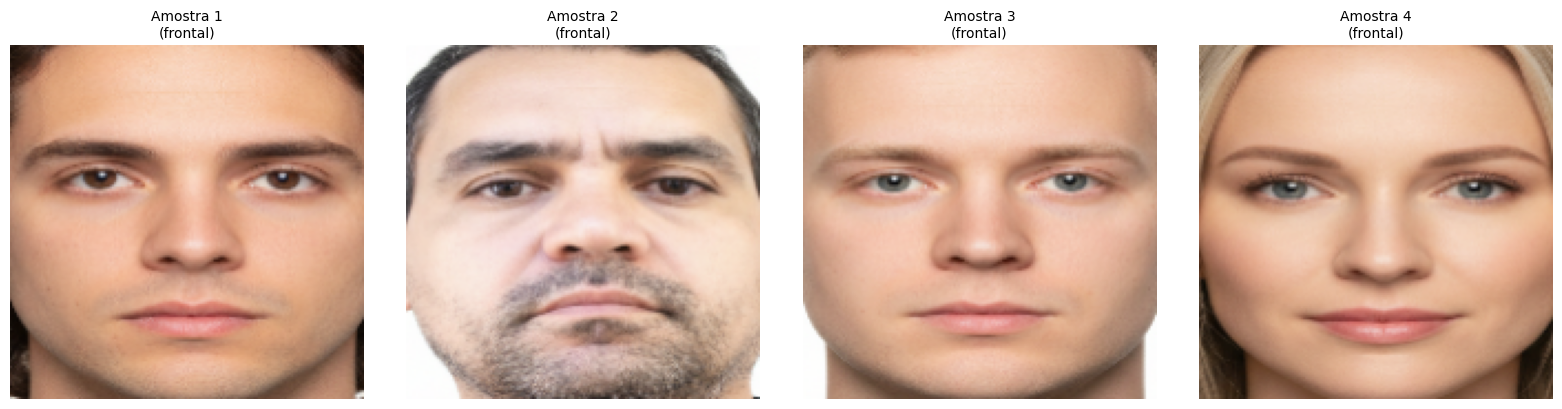

In [53]:
import matplotlib.pyplot as plt
from PIL import Image
import glob
import os

# --- Parte 1: Listar as Imagens (Reutilizando o Código Anterior) ---

# 1. Defina o caminho base da sua pasta
pasta_base = "/content/drive/MyDrive/Alunos"
caminho_busca = os.path.join(pasta_base, "**/*.png")

# Use glob.glob para encontrar todos os caminhos PNG
imagens_png = glob.glob(caminho_busca, recursive=True)

total_imagens = len(imagens_png)
print(f"Total de imagens PNG encontradas: {total_imagens}")

if total_imagens == 0:
    print("\n Nenhuma imagem PNG foi encontrada para plotar.")
else:
    # --- Parte 2: Plotar as Imagens ---

    # Define quantas imagens plotar (máximo de 4 para um grid 2x2)
    num_plots = min(4, total_imagens)

    # Cria a figura e os subplots (Ex: 2 linhas, 2 colunas para 4 imagens)
    fig, axes = plt.subplots(1, num_plots, figsize=(4 * num_plots, 4))

    # Se houver apenas 1 imagem, 'axes' não é um array, então o transformamos para facilitar o loop
    if num_plots == 1:
        axes = [axes]

    print(f"Plotando as primeiras {num_plots} imagens encontradas...")

    # Itera sobre as imagens a serem plotadas
    for i in range(num_plots):
        img_path = imagens_png[i]

        try:
            # 1. Carrega a imagem usando PIL (Pillow)
            img = Image.open(img_path)

            # 2. Exibe a imagem no subplot
            axes[i].imshow(img)

            # 3. Define o título do subplot
            # Tenta inferir a "classe" (frontal, lateral_esquerda, etc.) do nome do diretório
            partes_caminho = img_path.split(os.sep)
            # A classe é, provavelmente, o nome da subpasta logo antes do nome do arquivo
            # Ex: /Alunos/frontal/img.png -> "frontal"

            # Garante que a classe não é 'Alunos' ou algo anterior
            try:
                # Procura o diretório que está logo depois de 'Alunos'
                indice_alunos = partes_caminho.index('Alunos')
                # O rótulo (classe) é o item seguinte, se existir
                if indice_alunos + 1 < len(partes_caminho) - 1:
                    rotulo = partes_caminho[indice_alunos + 1]
                else:
                    # Se não houver subpasta, usa o nome do arquivo
                    rotulo = os.path.basename(img_path)
            except ValueError:
                 # Caso a pasta 'Alunos' não esteja na estrutura, usa o nome do arquivo
                rotulo = os.path.basename(img_path)

            axes[i].set_title(f"Amostra {i+1}\n({rotulo})", fontsize=10)
            axes[i].axis('off') # Remove os eixos

        except Exception as e:
            axes[i].set_title(f"Erro ao Carregar {i+1}", fontsize=10)
            axes[i].text(0.1, 0.5, "Imagem não carregada", transform=axes[i].transAxes)
            print(f"Erro ao carregar a imagem {img_path}: {e}")

    # Ajusta o layout para evitar sobreposição
    plt.tight_layout()
    plt.show()

In [57]:
import tensorflow as tf
from pathlib import Path

# --- Parâmetros ---
IMAGE_DIR = '/content/drive/MyDrive/Alunos/'
IMAGE_SIZE = (160, 160)
BATCH_SIZE = 32
SEED = 42
VALIDATION_SPLIT = 0.2

print(f"Buscando imagens no diretório: {IMAGE_DIR}")

# 1. Criação do Dataset de Treinamento
try:
    train_ds = tf.keras.utils.image_dataset_from_directory(
      IMAGE_DIR,
      labels='inferred',
      label_mode='int',
      color_mode='rgb',
      image_size=IMAGE_SIZE,
      interpolation='bilinear',
      batch_size=BATCH_SIZE,
      seed=SEED,
      shuffle=True,
      validation_split=VALIDATION_SPLIT,
      subset='training'
    )

    # 2. Criação do Dataset de Validação
    val_ds = tf.keras.utils.image_dataset_from_directory(
      IMAGE_DIR,
      labels='inferred',
      label_mode='int',
      color_mode='rgb',
      image_size=IMAGE_SIZE,
      interpolation='bilinear',
      batch_size=BATCH_SIZE,
      seed=SEED,
      shuffle=True,
      validation_split=VALIDATION_SPLIT,
      subset='validation'
    )

    # *** CORREÇÃO IMPORTANTE AQUI ***
    # Salve class_names AGORA, antes de aplicar o mapeamento e prefetch!
    class_names = train_ds.class_names
    num_classes = len(class_names)

    # 3. Normalização: Reescalona os pixels de [0, 255] para [0, 1]
    normalization_layer = tf.keras.layers.Rescaling(1./255)
    train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
    val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

    # 4. Configuração para Desempenho (Cache e Prefetch)
    AUTOTUNE = tf.data.AUTOTUNE
    train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
    val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

    # --- Resultados Finais ---
    # Agora class_names está disponível para impressão
    print("\n" + "="*60)
    print(" Dataset Criado, Configurado e PRONTO! ")
    print("="*60)
    print(f"Classes (Subpastas) Inseridas: {class_names}")
    print(f"Total de Classes: {num_classes}")

    # Estimativa de número de elementos
    train_batches = tf.data.experimental.cardinality(train_ds).numpy()
    val_batches = tf.data.experimental.cardinality(val_ds).numpy()

    print(f"Dataset de Treinamento: {train_batches} batches de {BATCH_SIZE} imagens (Total aprox. {train_batches * BATCH_SIZE})")
    print(f"Dataset de Validação: {val_batches} batches de {BATCH_SIZE} imagens (Total aprox. {val_batches * BATCH_SIZE})")
    print("\nDataset pronto para ser usado no método `.fit()` do modelo.")

except Exception as e:
    print("\n" + "="*60)
    print(" ERRO FATAL AO CARREGAR O DATASET! ")
    print("="*60)
    print(f"Detalhes do Erro: {e}")
    print("Atenção: Verifique se o Google Drive está montado e se a pasta possui subdiretórios.")

Buscando imagens no diretório: /content/drive/MyDrive/Alunos/
Found 28 files belonging to 3 classes.
Using 23 files for training.
Found 28 files belonging to 3 classes.
Using 5 files for validation.

 Dataset Criado, Configurado e PRONTO! 
Classes (Subpastas) Inseridas: ['frontal', 'lateral_direita', 'lateral_esquerda']
Total de Classes: 3
Dataset de Treinamento: 1 batches de 32 imagens (Total aprox. 32)
Dataset de Validação: 1 batches de 32 imagens (Total aprox. 32)

Dataset pronto para ser usado no método `.fit()` do modelo.


In [59]:
from tensorflow.keras import layers, models
import tensorflow as tf

# --- Configurações do Dataset ---
# **CORREÇÃO 1: Defina num_classes = 3**
# Baseado na saída anterior: "Found 28 files belonging to 3 classes."
num_classes = 3

# Supondo que você definiu IMAGE_SIZE na célula anterior (IMAGE_SIZE = (160, 160))
# Se IMAGE_SIZE não estiver definido, descomente a linha abaixo:
# IMAGE_SIZE = (160, 160)

# --- Aumento de Dados (Data Augmentation) ---
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.08),
], name='data_augmentation_layer')

# --- Modelo Base (MobileNetV2) ---
base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMAGE_SIZE + (3,),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # Congela as camadas da MobileNetV2

# --- Construção do Modelo ---
model = models.Sequential([
    data_augmentation,
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.4),
    # **CORREÇÃO 2: Use 'activation' em vez de 'ativação'**
    layers.Dense(num_classes, activation='softmax', name='prediction_output')
])

# --- Compilação do Modelo ---
# **CORREÇÃO 3: Use os termos em inglês na compilação**
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# --- Resumo do Modelo ---
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ data_augmentation_layer         │ ?                      │   0 (unbuilt) │
│ (Sequential)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ ?                      │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ prediction_output (Dense)       │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

Dataset pronto! Treinando em 3 classes: ['frontal', 'lateral_direita', 'lateral_esquerda']

Iniciando o treinamento por até 30 épocas...
Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 521ms/step - accuracy: 0.4348 - loss: 1.1018
Epoch 1: val_accuracy improved from -inf to 0.60000, saving model to /content/face_classifier_mobilenetv2.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 935ms/step - accuracy: 0.4348 - loss: 1.1018 - val_accuracy: 0.6000 - val_loss: 1.2526 - learning_rate: 1.0000e-05
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 658ms/step - accuracy: 0.4348 - loss: 1.1727
Epoch 2: val_accuracy did not improve from 0.60000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 729ms/step - accuracy: 0.4348 - loss: 1.1727 - val_accuracy: 0.6000 - val_loss: 1.2485 - learning_rate: 1.0000e-05
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 599ms/step - accuracy: 0.4783 - loss: 0.9014
Epoch 3: val_accuracy did not improve from 0.60000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 668ms/step - accuracy: 0.4783 - loss: 0.9014 - val_accuracy: 0.6000 - val_loss: 1.2451 - learning_rate: 1.0000e-05
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 612ms/step - accuracy: 0.4783 - loss: 1.1041
Epoch 4: val_accuracy did not improve from 0.60000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 693ms/step - accuracy: 0.4783 - loss: 1.1041 - val_accuracy: 0.4000 - val_loss: 1.2413 - learning_rate: 1.0000e-05
Epoch 5/30
1/1 ━━━━━━━━

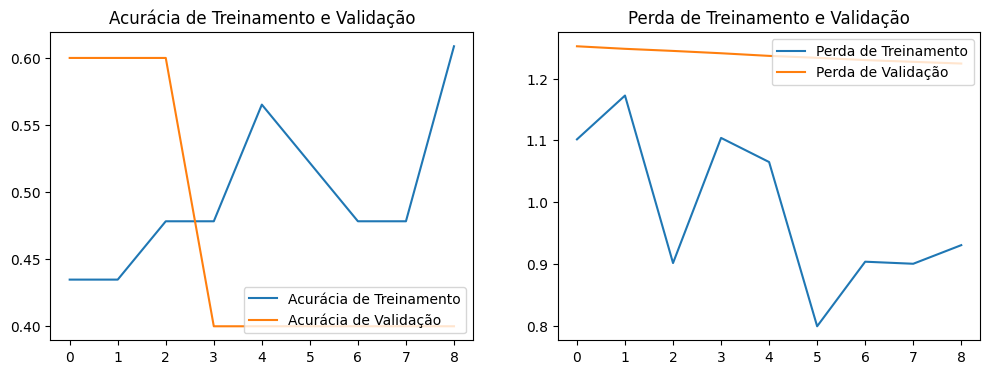

In [71]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np

# --- Verificação de Variáveis (Essencial) ---

# Tenta acessar 'train_ds' e 'val_ds'
try:
    # Captura os nomes das classes que foram definidas na célula anterior de criação do Dataset
    if 'class_names' in locals():
        print(f"Dataset pronto! Treinando em {len(class_names)} classes: {class_names}")
    else:
        print("Aviso: 'class_names' não está definido. Acurácia será plotada sem rótulos de classe.")

    train_ds is not None # Dispara NameError se a variável não existir
    # Verifica se o 'model' (do MobileNetV2) foi definido corretamente
    model is not None
except NameError as e:
    print(f"\n ERRO FATAL: Uma variável crucial não está definida. ({e})")
    print("Por favor, execute as células anteriores: 1. Criação do Dataset, 2. Definição do Modelo.")
    raise # Interrompe a execução

# --- Configuração de Callbacks e Parâmetros ---

CKPT_PATH = '/content/face_classifier_mobilenetv2.h5'
EPOCHS = 30 # Aumentamos um pouco as épocas, pois o EarlyStopping irá pará-lo

callbacks = [
    # Salva o MELHOR modelo baseado na acurácia de validação
    ModelCheckpoint(CKPT_PATH, monitor='val_accuracy', save_best_only=True, verbose=1),
    # Para o treinamento se a acurácia de validação não melhorar por 8 épocas
    EarlyStopping(monitor='val_accuracy', patience=8, restore_best_weights=True, verbose=1),
    # Reduz a taxa de aprendizado se a perda de validação estagnar
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-6, verbose=1)
]


# --- Início do Treinamento ---

print(f"\nIniciando o treinamento por até {EPOCHS} épocas...")

if 'val_ds' in locals() and val_ds is not None:
    history = model.fit(train_ds,
                        validation_data=val_ds,
                        epochs=EPOCHS,
                        callbacks=callbacks)
else:
    print("Nota: val_ds não está disponível, treinamento sem dados de validação. Callbacks de validação serão ignorados.")
    history = model.fit(train_ds, epochs=EPOCHS, callbacks=callbacks)

print(" Treinamento concluído.")

# ----------------------------------------------------
# Plota a acurácia e a perda (Loss) ao longo das épocas
# ----------------------------------------------------

def plot_history(history):
    acc = history.history['accuracy']
    # A verificação 'val_accuracy' e 'val_loss' deve ser feita aqui,
    # pois o treinamento pode ter ocorrido sem validação.
    if 'val_accuracy' in history.history:
        val_acc = history.history['val_accuracy']
        val_loss = history.history['val_loss']
        plot_validation = True
    else:
        plot_validation = False

    loss = history.history['loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 4 if plot_validation else 6))

    # Gráfico de Acurácia
    plt.subplot(1, 2 if plot_validation else 1, 1)
    plt.plot(epochs_range, acc, label='Acurácia de Treinamento')
    if plot_validation:
        plt.plot(epochs_range, val_acc, label='Acurácia de Validação')
        plt.legend(loc='lower right')
        plt.title('Acurácia de Treinamento e Validação')
    else:
        plt.title('Acurácia de Treinamento')

    if plot_validation:
        # Gráfico de Perda (Loss) - Somente se houver validação
        plt.subplot(1, 2, 2)
        plt.plot(epochs_range, loss, label='Perda de Treinamento')
        plt.plot(epochs_range, val_loss, label='Perda de Validação')
        plt.legend(loc='upper right')
        plt.title('Perda de Treinamento e Validação')

    plt.show()

# Verifica se o treinamento incluiu validação antes de plotar
if 'accuracy' in history.history:
    plot_history(history)
else:
    print("\n Não foi possível plotar os gráficos, 'history' não contém os dados de treinamento esperados.")

In [72]:
base_model.trainable = True
fine_tune_at = 100  # libera apenas as últimas camadas

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

EPOCHS_FINE = 10
history_fine = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS_FINE, callbacks=callbacks)


Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.3913 - loss: 1.0640
Epoch 1: val_accuracy did not improve from 0.60000
1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step - accuracy: 0.3913 - loss: 1.0640 - val_accuracy: 0.4000 - val_loss: 1.2542 - learning_rate: 1.0000e-05
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 509ms/step - accuracy: 0.5217 - loss: 1.0128
Epoch 2: val_accuracy did not improve from 0.60000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 579ms/step - accuracy: 0.5217 - loss: 1.0128 - val_accuracy: 0.4000 - val_loss: 1.2549 - learning_rate: 1.0000e-05
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 538ms/step - accuracy: 0.4783 - loss: 1.0140
Epoch 3: val_accuracy did not improve from 0.60000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 601ms/step - accuracy: 0.4783 - loss: 1.0140 - val_accuracy: 0.4000 - val_loss: 1.2562 - learning_rate: 1.0000e-05
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 567ms/step - accuracy: 0.5652 - loss: 0.9727
Epoch 4: val_accuracy did not improve from 0.60000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 630ms/

In [73]:
!find /content -type f \( -iname "*.jpg" -o -iname "*.png" \) | head -n 20


/content/foto.jpg
/content/drive/MyDrive/Classroom/Matemática discreta/Screenshot_20221215-135352~2.png
/content/drive/MyDrive/github.jpg
/content/drive/MyDrive/IMG_20231020_185242.jpg
/content/drive/MyDrive/IMG_20231020_184503.jpg
/content/drive/MyDrive/Material Didatico/Apostilas/PmTech/Fluxo_PMBOK_6aEd_Mauro_Sotille.jpg
/content/drive/MyDrive/Material Didatico/Modelos Documentos/PMO/EAP baseada nas principais saidas do Guia PMBOK Quinta Edicao.png
/content/drive/MyDrive/Material Didatico/Resumo/Resumo.jpg
/content/drive/MyDrive/sladbar_carrosel/images/img-2.jpg
/content/drive/MyDrive/sladbar_carrosel/images/img-1.jpg
/content/drive/MyDrive/sladbar_carrosel/images/img-8.jpg
/content/drive/MyDrive/sladbar_carrosel/images/img-4.jpg
/content/drive/MyDrive/sladbar_carrosel/images/img-10.jpg
/content/drive/MyDrive/sladbar_carrosel/images/img-5.jpg
/content/drive/MyDrive/sladbar_carrosel/images/img-9.jpg
/content/drive/MyDrive/sladbar_carrosel/images/img-3.jpg
/content/drive/MyDrive/sladb

Exemplo de imagem selecionada: /content/drive/MyDrive/Alunos/lateral_direita/aluno01.png
Detectadas 1 faces


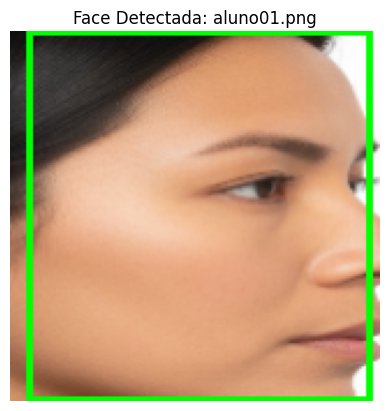

In [74]:
from mtcnn import MTCNN
import cv2
import matplotlib.pyplot as plt
from pathlib import Path
import os
import random # Importar para pegar uma amostra aleatória

# --- 1. Definir a Pasta Raiz Correta ---
# Usamos o caminho da sua pasta no Google Drive
DATASET_ROOT = Path('/content/drive/MyDrive/Alunos/')

# --- 2. Busca Recursiva por Imagens e Tratamento de Erro ---
# Buscamos por .jpg E .png
image_files = []
image_files.extend(list(DATASET_ROOT.rglob("*.jpg")))
image_files.extend(list(DATASET_ROOT.rglob("*.jpeg"))) # Boa prática incluir .jpeg
image_files.extend(list(DATASET_ROOT.rglob("*.png")))


if not image_files:
    print(f" Erro: Nenhuma imagem (.jpg, .jpeg, .png) foi encontrada em '{DATASET_ROOT}'.")
    print("Verifique se o Google Drive está montado e se o caminho está correto.")
else:
    # --- 3. Execução do Detector (com uma imagem aleatória) ---
    # Pegamos uma imagem aleatória para garantir que não dependemos da ordem [0]
    img_path_obj = random.choice(image_files)
    img_path = str(img_path_obj)

    print("Exemplo de imagem selecionada:", img_path)

    # Carregar a imagem
    img = cv2.imread(img_path)

    if img is None:
        print(f" Erro: Não foi possível carregar a imagem em {img_path}. O arquivo pode estar corrompido.")
    else:
        # Converter para RGB (MTCNN espera RGB)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Inicializar e detectar faces
        detector = MTCNN()
        faces = detector.detect_faces(img_rgb)

        print(f"Detectadas {len(faces)} faces")

        # Plotar se houver faces
        if faces:
            # Pega as coordenadas da primeira face detectada
            x, y, w, h = faces[0]['box']

            # Desenha o retângulo (Bounding Box)
            cv2.rectangle(img_rgb, (x, y), (x + w, y + h), (0, 255, 0), 2)

            # Exibe a imagem
            plt.imshow(img_rgb)
            plt.title(f"Face Detectada: {os.path.basename(img_path)}")
            plt.axis('off')
            plt.show()
        else:
            print("Nenhuma face detectada nesta imagem. Exibindo imagem original.")
            plt.imshow(img_rgb)
            plt.title("Nenhuma Face Detectada")
            plt.axis('off')
            plt.show()
